In [1]:
# add autocbh package to path
import sys
sys.path.append('../autocbh')

# import relevant rdkit 
from rdkit import Chem
# drawing tools used for CBH.buildCBH visualization
from rdkit.Chem import Draw, rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
from IPython.display import SVG, display

# Import CBH generator
from CBH import buildCBH
from calcCBH import calcCBH
from TN import thermochemical_network, visualize
from UQ import uncertainty_quantification

# only needed for np.inf example for now
import numpy as np
from numpy import inf
import pandas as pd
import yaml
import matplotlib.pyplot as plt

with open('../data/alias_manual_2.yaml', 'r') as f:
    alias = yaml.safe_load(f)
alias_rev = {v:k for k, v in alias.items()}

In [38]:
saturate = [1,9]
max_rung = None
alt_rxn_option = 'include'
priority = 'rel_coeff'

In [39]:
c.calc_Hf_allrungs('FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F')[1]

,0,1,2,3,4,5,6,7,8
ref,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
anl0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f12b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m062x_dlpno,-3746.935671,-3753.481290,-3765.126667,-3777.491085,-3794.184141,-3794.184141,-3794.184141,-3794.184141,-3794.184141
wb97xd_dlpno,-3754.866950,-3752.173767,-3766.160480,-3778.619956,-3796.218971,-3796.218971,-3796.218971,-3796.218971,-3796.218971
b2plypd3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m062x,-4109.440863,-3851.356341,-3798.025884,-3776.729940,-3793.583817,-3793.583817,-3793.583817,-3793.583817,-3793.583817
wb97xd,-3934.543197,-3811.519633,-3791.244218,-3786.625449,-3793.838491,-3793.838491,-3793.838491,-3793.838491,-3793.838491


In [40]:
c.rxns['O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F']

{'H': {'CC(F)(F)C(F)(F)C(=O)O': 1,
  'CC(F)(F)C(F)(F)C(F)(F)F': 1,
  'CC(F)(F)C(F)(F)C(C)(F)F': 4,
  'CC(F)(F)C(C)(F)F': -5},
 'F': {'O=C(O)C(F)(F)C(F)(F)F': 1,
  'FC(F)(F)C(F)(F)C(F)(F)C(F)(F)F': 5,
  'FC(F)(F)C(F)(F)C(F)(F)F': -5}}

In [41]:
# Initialize module
c = calcCBH(methods=[], # CHANGED
            dataframe_path='../data/pfas_energies.pkl', # supply pickled dataframe 
            method_keys_path='../data/methods_keys.yaml', # supply yaml file mapping method names to each QM energy column name
            rankings_path='../data/rankings.yaml', # supply yaml file mapping each method to a level of theory ranking
            zero_out_heats=True,
            alternative_rxn_path='../data/alternative_rxn_v5.yaml') # ensures that the heats of formation/rxn for nonexperimental values are converted to 0 from nan

c.calc_Hf(saturate=saturate, # only use CBH-H
          max_rung=max_rung, # can choose a maximum rung, otherwise will do highest possible
          alt_rxn_option=alt_rxn_option, 
          priority=priority)

Process completed with errors in 33 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


,DfH,DrxnH,source
smiles,,,
F,-272.680000,0.000000,ATcT
O,-238.898000,0.000000,ATcT
[H][H],0.000000,0.000000,ATcT
C,-66.551000,0.000000,ATcT
CF,-227.480000,0.000000,ATcT
...,...,...,...
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3384.998876,2.032257,"CBHavg-(4-H, 3-F)//m062x_dlpno+wb97xd_dlpno"
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(C)(F)F,-2618.219160,1.031481,"CBHavg-(4-H, 3:4-F)//m062x_dlpno+wb97xd_dlpno"
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3206.109219,2.353831,"CBHavg-(4-H, 3:4-F)//m062x_dlpno"


In [42]:
c.print_errors()

CC(O)(F)F:

	This species was decomposed from CBH-1-F to be made up of species from CBH-F: ['0', '1']
	Beware that the logged rungs may not be fully representative. 
	They are drawn only from comparing reference species to this specific saturation scheme.
	It is possible that the decomposed reaction contains higher or lower rungs from other saturation schemes.
	Check self.rxns attribute for accurate representation.


O=C(O)C(F)(F)F:

	This species was decomposed from CBH-1-F to be made up of species from CBH-F: ['0', '1']
	Beware that the logged rungs may not be fully representative. 
	They are drawn only from comparing reference species to this specific saturation scheme.
	It is possible that the decomposed reaction contains higher or lower rungs from other saturation schemes.
	Check self.rxns attribute for accurate representation.


OC(F)(C(F)(F)F)C(F)(F)F:

	All precursor species for CBH-3-H had the same level of theory. 
	The reaction was decomposed into each precursors' substituen

In [43]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 1):
    print(c.energies.loc[:,'source'])

smiles
F                                                                                                      ATcT
O                                                                                                      ATcT
[H][H]                                                                                                 ATcT
C                                                                                                      ATcT
CF                                                                                                     ATcT
CO                                                                                                     ATcT
FCF                                                                                                    ATcT
C=O                                                                                                    ATcT
FC(F)F                                                                                                 ATcT
O=C(F)F              

In [44]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 1):
    print(c.energies.loc[:,'DfH'])

smiles
F                                                             -272.680000
O                                                             -238.898000
[H][H]                                                           0.000000
C                                                              -66.551000
CF                                                            -227.480000
CO                                                            -190.040000
FCF                                                           -443.380000
C=O                                                           -105.389000
FC(F)F                                                        -689.340000
O=C(F)F                                                       -603.360000
OC(F)(F)F                                                     -901.627325
FC(F)(F)F                                                     -927.770000
CC                                                             -68.390000
COC                            

In [13]:
uq = uncertainty_quantification(10000, dataframe_path='../data/pfas_energies.pkl', saturate=[1,9], 
                                method_keys_path='../data/methods_keys.yaml', 
                                rankings_path='../data/rankings.yaml', 
                                zero_out_heats=True,
                                alternative_rxn_path='../data/alternative_rxn_v5.yaml',
                                priority='rel_coeff', alt_rxn_option="ignore")
uq.run()

Process completed with errors in 33 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


Number of Species: 100%|███████████████████████| 53/53 [00:00<00:00, 244.09it/s]


In [5]:
uq = uncertainty_quantification(10000, dataframe_path='../data/pfas_energies.pkl', saturate=[1,9], 
                                method_keys_path='../data/methods_keys.yaml', 
                                rankings_path='../data/rankings.yaml', 
                                zero_out_heats=True,
                                alternative_rxn_path='../data/alternative_rxn_v5.yaml',
                                priority='rel_coeff', alt_rxn_option="ignore")
uq.run()

Process completed with errors in 22 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


Number of Species: 100%|████████████████████████| 53/53 [00:03<00:00, 15.83it/s]


In [2]:
uq2 = uncertainty_quantification(10000, dataframe_path='../data/pfas_energies.pkl', saturate=[1,9], 
                                method_keys_path='../data/methods_keys.yaml', 
                                rankings_path='../data/rankings.yaml', 
                                zero_out_heats=True,
                                alternative_rxn_path='../data/alternative_rxn_v5.yaml',
                                priority='rel_coeff', alt_rxn_option="ignore")
uq2.run(True)

Process completed with errors in 22 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


Number of Species: 100%|███████████████████████| 53/53 [00:00<00:00, 235.65it/s]


In [6]:
uq.simulation_results.std(axis=1) - uq2.simulation_results.std(axis=1)

array([-2.22989954e-05,  1.44750419e-04,  0.00000000e+00,  1.89702839e-04,
       -2.22823071e-03,  1.10028048e-04, -1.17429803e-03, -4.98821273e-06,
       -5.96214091e-04,  6.57816613e-04, -4.62841105e-05, -4.60101829e-04,
        7.46558869e-04,  1.49956297e-03,  5.41070339e-04,  4.64550097e-04,
       -8.39393968e-02, -9.47228344e-03, -1.94105222e-05,  2.01078974e-04,
        2.04116497e-03,  1.13215360e-03,  1.68581776e-02, -7.90276928e-03,
        1.61750021e-03,  1.19954446e-03, -1.17296341e-02, -1.13850102e-02,
       -4.28086912e-04, -7.34989916e-02,  5.94373366e-02,  2.61896859e-01,
       -2.24599410e-02, -3.23979944e-02, -2.23172786e-02, -1.70787558e-02,
       -3.55157633e-03,  2.10037963e-01,  3.20945458e-02,  7.60369417e-02,
       -5.86423410e-03, -9.87218001e-03, -8.33559409e-03, -3.16022501e-02,
       -7.20696425e-03,  6.42629380e-02, -2.56434949e-02,  1.66130466e-01,
        2.27635938e-01, -2.97888560e-02,  3.35297652e-03,  8.86390490e-02,
        5.76079304e-02, -

In [21]:
tn = thermochemical_network(uq.calcCBH)
tn2 = thermochemical_network(uq2.calcCBH)

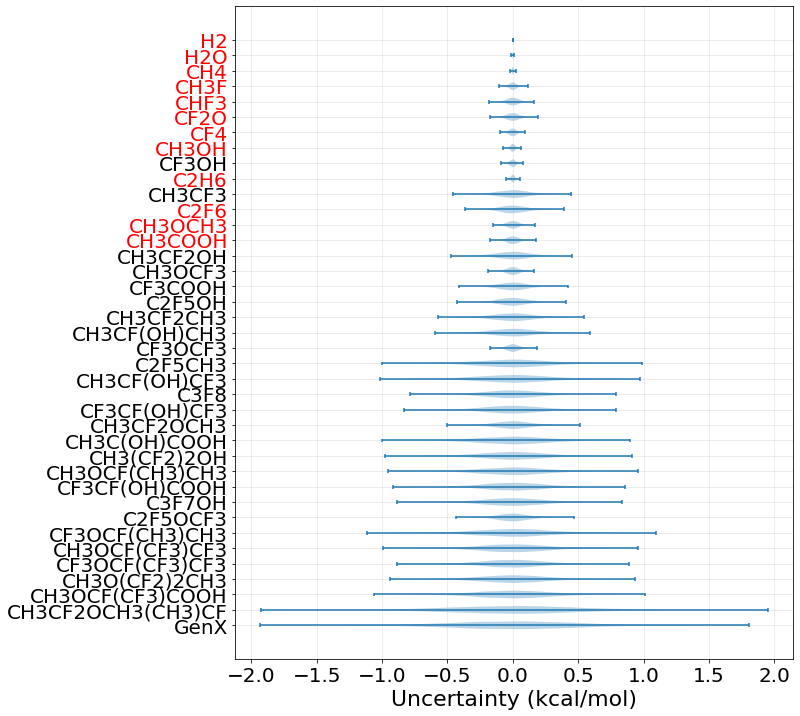

In [22]:
subgraph = tn.descendent_subgraph_of('O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F')
inds = [s in list(subgraph.nodes) for i, s in enumerate(uq.species)]

normalized_simresults = uq.simulation_results[inds] - np.expand_dims(uq.simulation_results[inds].mean(axis=1), axis=-1)
df = pd.DataFrame(normalized_simresults, index=uq.species[inds])
sorted_inds = sorted(df.index.values, key=uq.simple_sort)[::-1]
alias_sorted_names = [alias_rev[s] for s in sorted_inds]

exp_smiles = [s for s in uq.species[inds] if len(uq.calcCBH.energies.loc[s,'source'].split('//'))==1]

fig, ax = plt.subplots(1,1, figsize=(10,12))
ax.violinplot(df.loc[sorted_inds].T/4.184, vert=False)
ax.set_yticks(ticks=np.arange(len(alias_sorted_names))+1, labels=alias_sorted_names, fontsize=20)
plt.xticks(fontsize=20)
for s in exp_smiles:
    if alias_rev[s] in alias_sorted_names:
        ind = alias_sorted_names.index(alias_rev[s])
        ax.get_yticklabels()[ind].set_color("red")
plt.grid(True, axis='both', alpha=0.3)
plt.xlabel('Uncertainty (kcal/mol)', fontsize=22)
# plt.savefig('../figures/UQ_pfoa_rel.svg')
plt.show()

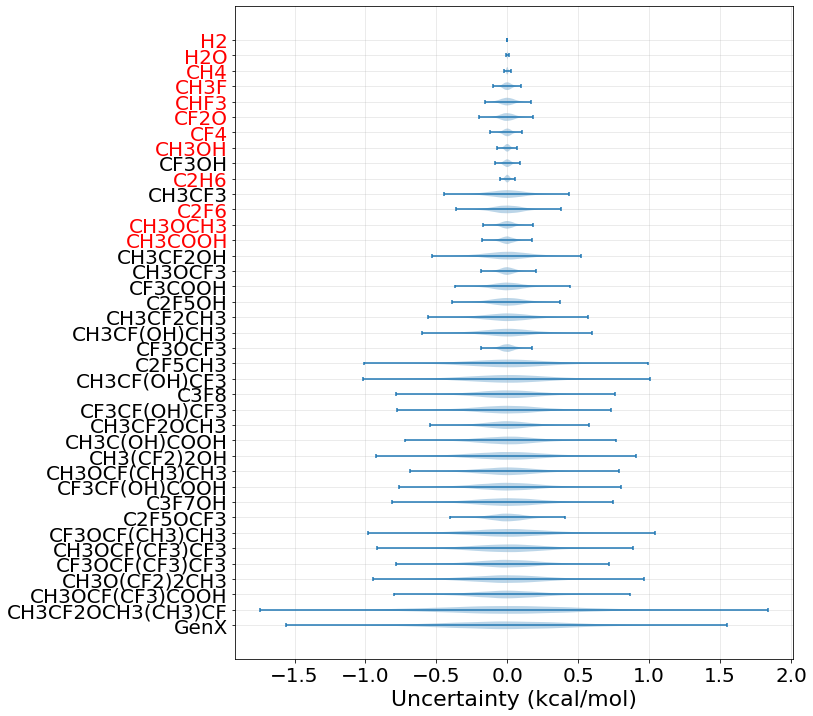

In [23]:
subgraph = tn2.descendent_subgraph_of('O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F')
inds = [s in list(subgraph.nodes) for i, s in enumerate(uq2.species)]

normalized_simresults = uq2.simulation_results[inds] - np.expand_dims(uq2.simulation_results[inds].mean(axis=1), axis=-1)
df = pd.DataFrame(normalized_simresults, index=uq2.species[inds])
sorted_inds = sorted(df.index.values, key=uq2.simple_sort)[::-1]
alias_sorted_names = [alias_rev[s] for s in sorted_inds]

exp_smiles = [s for s in uq2.species[inds] if len(uq2.calcCBH.energies.loc[s,'source'].split('//'))==1]

fig, ax = plt.subplots(1,1, figsize=(10,12))
ax.violinplot(df.loc[sorted_inds].T/4.184, vert=False)
ax.set_yticks(ticks=np.arange(len(alias_sorted_names))+1, labels=alias_sorted_names, fontsize=20)
plt.xticks(fontsize=20)
for s in exp_smiles:
    if alias_rev[s] in alias_sorted_names:
        ind = alias_sorted_names.index(alias_rev[s])
        ax.get_yticklabels()[ind].set_color("red")
plt.grid(True, axis='both', alpha=0.3)
plt.xlabel('Uncertainty (kcal/mol)', fontsize=22)
# plt.savefig('../figures/UQ_pfoa_rel.svg')
plt.show()

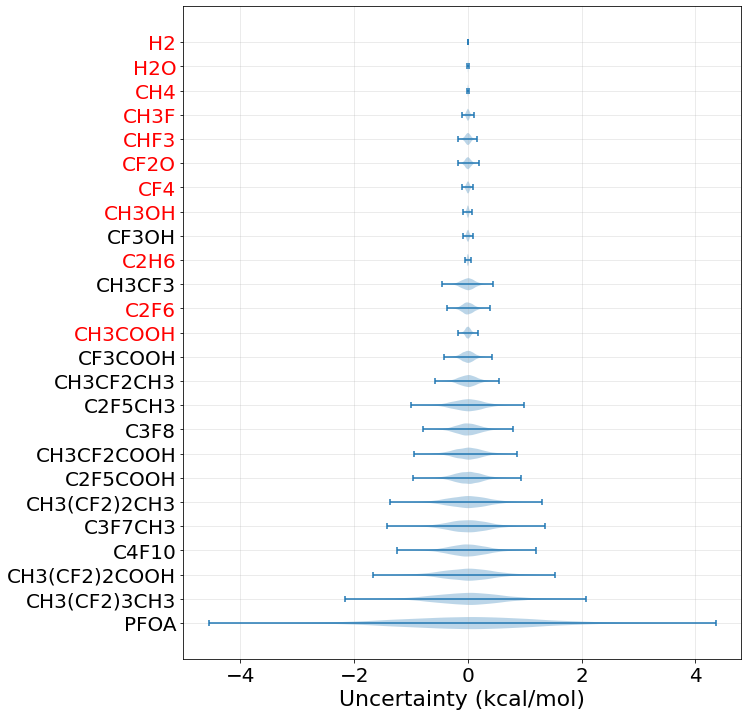

In [24]:
subgraph = tn.descendent_subgraph_of('O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F')
inds = [s in list(subgraph.nodes) for i, s in enumerate(uq.species)]

normalized_simresults = uq.simulation_results[inds] - np.expand_dims(uq.simulation_results[inds].mean(axis=1), axis=-1)
df = pd.DataFrame(normalized_simresults, index=uq.species[inds])
sorted_inds = sorted(df.index.values, key=uq.simple_sort)[::-1]
alias_sorted_names = [alias_rev[s] for s in sorted_inds]

exp_smiles = [s for s in uq.species[inds] if len(uq.calcCBH.energies.loc[s,'source'].split('//'))==1]

fig, ax = plt.subplots(1,1, figsize=(10,12))
ax.violinplot(df.loc[sorted_inds].T/4.184, vert=False)
ax.set_yticks(ticks=np.arange(len(alias_sorted_names))+1, labels=alias_sorted_names, fontsize=20)
plt.xticks(fontsize=20)
for s in exp_smiles:
    if alias_rev[s] in alias_sorted_names:
        ind = alias_sorted_names.index(alias_rev[s])
        ax.get_yticklabels()[ind].set_color("red")
plt.grid(True, axis='both', alpha=0.3)
plt.xlabel('Uncertainty (kcal/mol)', fontsize=22)
# plt.savefig('../figures/UQ_pfoa_rel.svg')
plt.show()

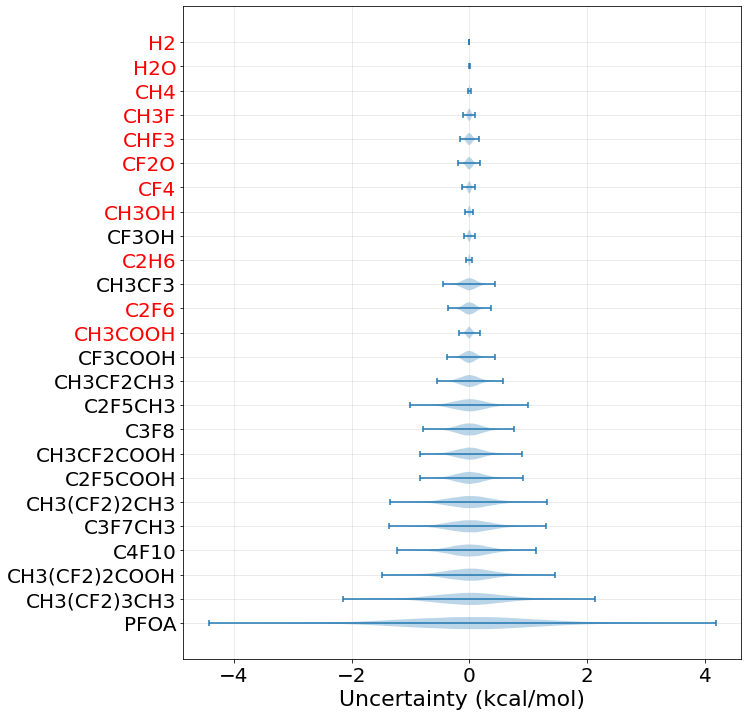

In [25]:
subgraph = tn2.descendent_subgraph_of('O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F')
inds = [s in list(subgraph.nodes) for i, s in enumerate(uq2.species)]

normalized_simresults = uq2.simulation_results[inds] - np.expand_dims(uq2.simulation_results[inds].mean(axis=1), axis=-1)
df = pd.DataFrame(normalized_simresults, index=uq2.species[inds])
sorted_inds = sorted(df.index.values, key=uq2.simple_sort)[::-1]
alias_sorted_names = [alias_rev[s] for s in sorted_inds]

exp_smiles = [s for s in uq2.species[inds] if len(uq2.calcCBH.energies.loc[s,'source'].split('//'))==1]

fig, ax = plt.subplots(1,1, figsize=(10,12))
ax.violinplot(df.loc[sorted_inds].T/4.184, vert=False)
ax.set_yticks(ticks=np.arange(len(alias_sorted_names))+1, labels=alias_sorted_names, fontsize=20)
plt.xticks(fontsize=20)
for s in exp_smiles:
    if alias_rev[s] in alias_sorted_names:
        ind = alias_sorted_names.index(alias_rev[s])
        ax.get_yticklabels()[ind].set_color("red")
plt.grid(True, axis='both', alpha=0.3)
plt.xlabel('Uncertainty (kcal/mol)', fontsize=22)
# plt.savefig('../figures/UQ_pfoa_rel.svg')
plt.show()

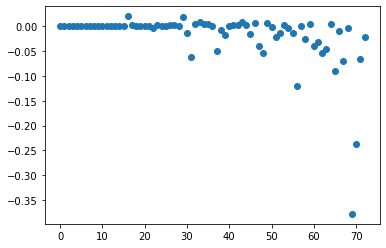

In [31]:
plt.scatter(range(len(uq2.simulation_results)), 1/4.184*(uq2.simulation_results.std(axis=1) - uq.simulation_results.std(axis=1)))